In [36]:
from sklearn.mixture import GaussianMixture

from IO.stero import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [37]:
# Load the data
gem_df = read_gem_file('F:\Adult.gem')
df = enhance_df_info(gem_df, bin_size=40)
adata = get_anndata(df)

In [39]:
adata

AnnData object with n_obs × n_vars = 18300 × 33149
    obs: 'cell_id', 'x', 'y', 'fig_x', 'fig_y'
    var: 'gene_ids'
    obsm: 'spatial'

F:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

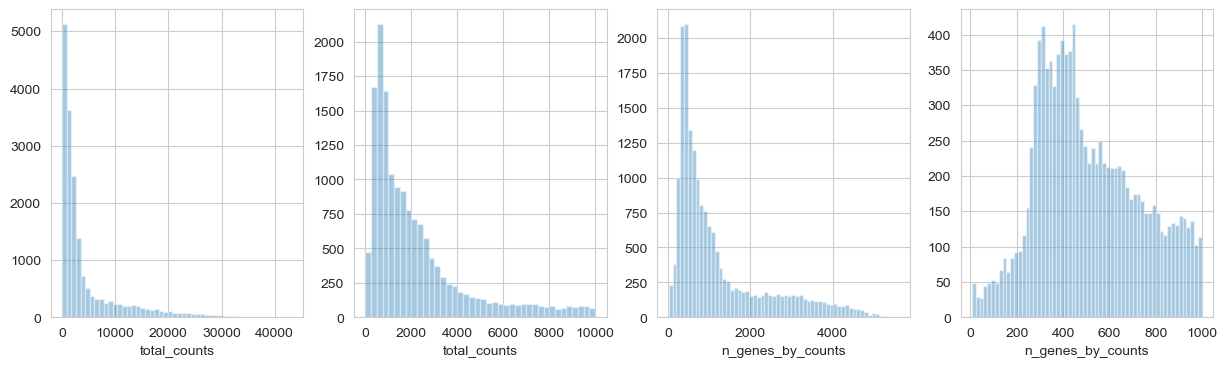

In [40]:
# filter out genes
sc.pp.filter_genes(adata, min_cells=180)
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [41]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
# Select top 2000 variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 18300 × 12245
    obs: 'cell_id', 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [42]:
gene_list = list(adata.var['gene_ids'])
gene_list[:5]

['AMEX60DD000048',
 'AMEX60DD000050',
 'AMEX60DD000054',
 'AMEX60DD000066',
 'AMEX60DD000120']

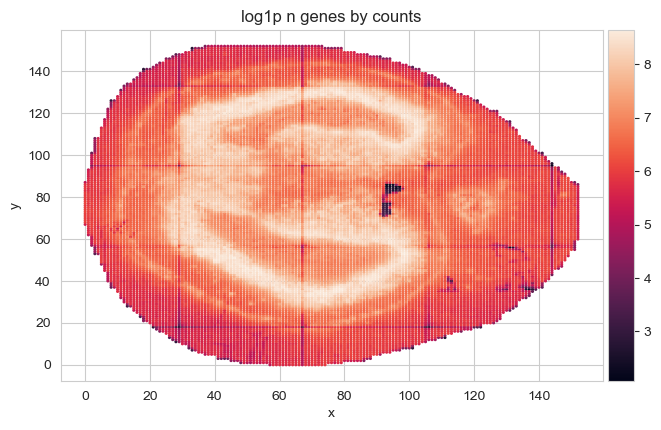

In [45]:
sc.pl.scatter(adata,
              x='x',
              y='y',
              color='log1p_n_genes_by_counts',
              size=20,
              palette=['#FF0000', '#00FF00', '#0000FF'])

In [47]:
gmm_dict = fit_gmms(adata, gene_list, n_comp=20)

Processing ...: 100%|██████████| 12245/12245 [20:02<00:00, 10.19it/s] 


Dropped genes:
['AMEX60DD007130', 'AMEX60DD013909', 'AMEX60DD046484', 'AMEX60DD002464', 'AMEX60DD005138', 'AMEX60DD006548', 'AMEX60DD015444', 'AMEX60DD020736', 'AMEX60DD020917', 'AMEX60DD024719', 'AMEX60DD032091', 'AMEX60DD035859', 'AMEX60DD050073', 'AMEX60DD056538', 'AMEX60DDU001022652', 'AMEX60DD000920', 'AMEX60DD004573', 'AMEX60DD006092', 'AMEX60DD017461', 'AMEX60DD018358', 'AMEX60DD021879', 'AMEX60DD036556', 'AMEX60DD036660', 'AMEX60DD040868', 'AMEX60DD047235', 'AMEX60DD051590', 'AMEX60DD052324', 'AMEX60DDU001001642', 'AMEX60DDU001010207', 'AMEX60DDU001041346', 'AMEX60DD023121', 'AMEX60DD031349', 'AMEX60DD033786', 'AMEX60DD036619', 'AMEX60DD036677', 'AMEX60DD049436', 'AMEX60DD055631', 'AMEX60DD056514', 'AMEX60DD056529', 'AMEX60DD001617', 'AMEX60DD006276', 'AMEX60DD021471', 'AMEX60DD022905', 'AMEX60DD028123', 'AMEX60DD033234', 'AMEX60DD039097', 'AMEX60DD054273', 'AMEX60DD056569', 'AMEX60DDU001030063', 'AMEX60DD000004', 'AMEX60DD000607', 'AMEX60DD002203', 'AMEX60DD002315', 'AMEX60DD0

Building distance array...:   0%|          | 50/12025 [24:32<97:56:27, 29.44s/it] 


KeyboardInterrupt: 

In [58]:
arr = build_distance_array(gmm_dict)
cluster(arr, n_clusters=20, mds_components=70)

Building distance array...:   0%|          | 3/12025 [01:39<110:46:34, 33.17s/it]


KeyboardInterrupt: 

In [50]:
gmm_dict['AMEX60DD013921'].covariances_

array([[[ 96.0550057 , -20.37822891],
        [-20.37822891,  38.2752783 ]],

       [[105.18985277,   1.3756689 ],
        [  1.3756689 ,  24.86091923]],

       [[107.932626  , -16.75647642],
        [-16.75647642,  28.9281389 ]],

       [[ 70.96887264,  -8.45883315],
        [ -8.45883315, 155.67026435]],

       [[ 38.18737636,   3.05375138],
        [  3.05375138,   8.43578269]],

       [[131.48846086, -42.67491042],
        [-42.67491042,  33.95330239]],

       [[ 87.17448192, -25.6860374 ],
        [-25.6860374 ,  41.0582277 ]],

       [[ 55.66099521,  -0.60365783],
        [ -0.60365783,  13.1180456 ]],

       [[ 53.58228887, -18.52367941],
        [-18.52367941,  72.8871419 ]],

       [[ 83.96964709, -84.22473102],
        [-84.22473102, 118.93936904]],

       [[ 91.50779859, -33.81675456],
        [-33.81675456,  24.98642932]],

       [[ 34.14440383,  24.33586955],
        [ 24.33586955, 173.12754114]],

       [[ 77.1431919 , -62.03840586],
        [-62.03840586,  60

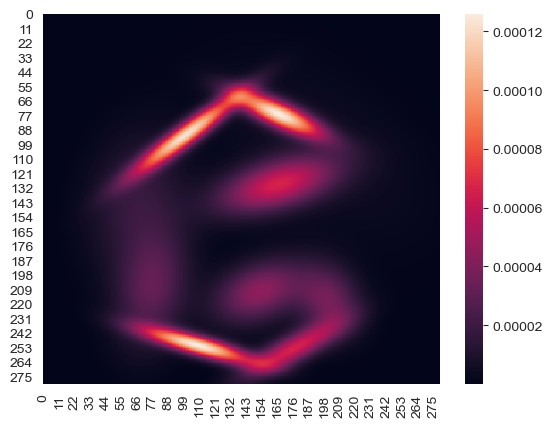

In [42]:
a = fit_gmm(adata, 'AMEX60DD000048')
view_gmm(a, (0,280))

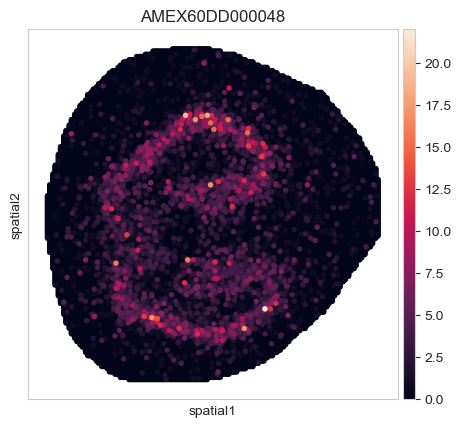

In [33]:
sc.pl.spatial(adata,
              size=5,
              spot_size=1,
              color=['AMEX60DD000048'])